# Detect a missile in an image with OpenCV and YOLO

In this article we will YOLO and COCO with Python to perform a simple missile detection on a static image.

In [1]:
import cv2 as cv
import numpy as np
import os
import time

from matplotlib import pyplot as plt

## Introduction

This example assumes that you have basic understanding of how to work with YOLO, COCO, and OpenCV in Python.

In case you don't feel comfortable with the mentioned technologies yet, here is a simple OpenCV & YOLO tutorial:

 * my [Medium article](https://medium.com/@mikolaj.buchwald/yolo-and-coco-object-recognition-basics-in-python-65d06f42a6f8) (Mikolaj Buchwald);
 * [GitHub repository](https://github.com/mikbuch/yolo-coco-opencv-example) with code examples;
 * a direct link to the [Jupyter Notebook with a simple OpenCV & YOLO example](https://github.com/mikbuch/yolo-coco-opencv-example/blob/main/YOLO%20%26%20COCO%20basics%20in%20Python.ipynb).

See also: https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html

---

## Materials for the current notebook

In this tutorial, we will be working with the following image: https://upload.wikimedia.org/wikipedia/commons/4/4e/Neptune_cruise_missile_05.jpg (link to wikipedia the article featuring this image: https://en.wikipedia.org/wiki/Neptune_(cruise_missile)).

So first, let's load and display this picture.

In [2]:
img_name = 'missile.jpg'

img = cv.imread(img_name) 

### Color conversion

Matplotlib interprets images in RGB format, but OpenCV uses BGR format

Hence, in order to convert the image, so that it is properly loaded, colors need to be converted before loading an image.

See: https://www.codegrepper.com/code-examples/python/imshow+wrong+colors

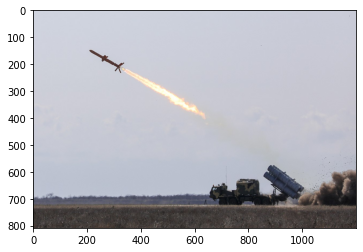

In [3]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

### COCO names

COCO names file (`coco.names`) is included in the repository with the code. You can also download it manually, if you wish, using [this link](https://opencv-tutorial.readthedocs.io/en/latest/_downloads/a9fb13cbea0745f3d11da9017d1b8467/coco.names). Here is also a preview of the file contents: https://github.com/mikbuch/yolo-coco-opencv-example/blob/main/coco.names

### YOLO configuration and weights

YOLO configuration (`yolov3.cfg`) also will be available for you in the repository (or you can download it manually from [here](https://pjreddie.com/media/files/yolov3.weights)).


#### Downloading the YOLO weights

The `yolov3.weights` file is pretty large, so it wouldn't the best idea to include it in the repository with this example. We will have to make sure that this file is available for you -- by downloading the file:

In [4]:
!wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights

--2023-02-22 15:27:22--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  1.90MB/s    in 1m 59s  

2023-02-22 15:29:22 (1.98 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



Having gathered all the required files, we can proceed to running the image through the network.

Blob shape=(1, 3, 416, 416)


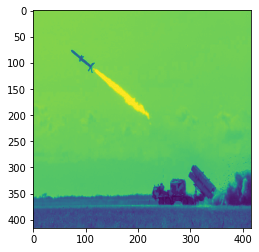

In [5]:
# Load names of classes and get random colors
classes = open('coco.names').read().strip().split('\n')
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

# Give the configuration and weight files for the model and load the network.
net = cv.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
# net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

# Determine the output layer
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

# construct a blob from the image
blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
r = blob[0, 0, :, :]

plt.imshow(r)
print('Blob shape=%s' % (blob.shape,))

In [6]:
net.setInput(blob)
t0 = time.time()
outputs = net.forward(ln)
t = time.time()
print('time=', t-t0)

print(len(outputs))
for out in outputs:
    print(out.shape)

time= 0.49222826957702637
3
(507, 85)
(2028, 85)
(8112, 85)


### Bounding boxes and object classes

Now we will restrict all the found objects to these where confidence interval exceedes 50%. We will also add bounding boxes to the image.

In [7]:
boxes = []
confidences = []
classIDs = []
h, w = img.shape[:2]

for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.5:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
        # In order to see also the labels and confidence uncomment the two following lines
        #text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        #cv.putText(img, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

### Saving the image as a file

In [8]:
cv.imwrite(('output_%s' % img_name), img)

True

## Show image with the bounding boxes

### Color conversion

Matplotlib interprets images in RGB format, but OpenCV uses BGR format. Hence, in order to convert the image, so that it is properly loaded, colors need to be converted before loading an image (see: https://www.codegrepper.com/code-examples/python/imshow+wrong+colors).

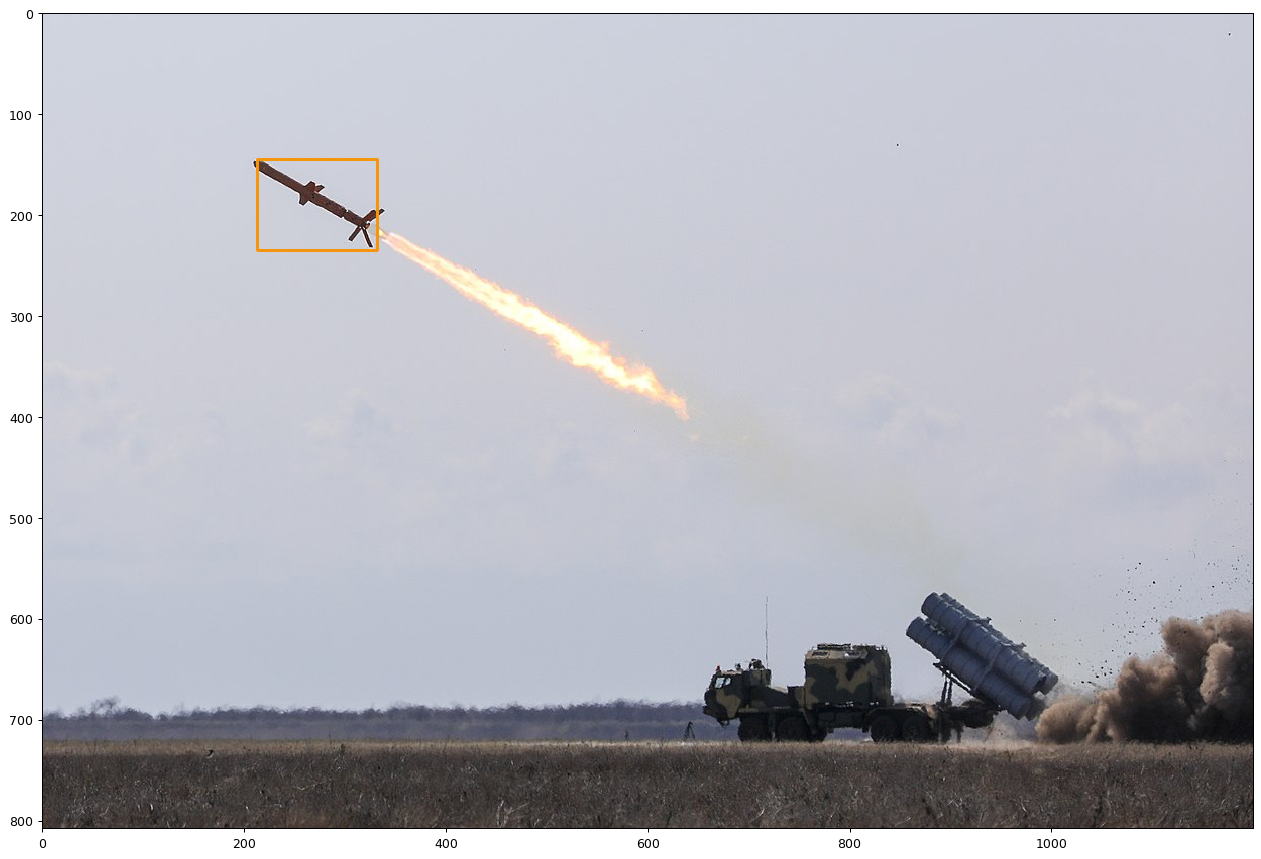

In [9]:
fig, ax = plt.subplots(figsize=(20, 12), dpi=90)
ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB), interpolation='none')